In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("./Data/balanced_urls_clean.csv")

In [4]:
df.head()
df.drop(columns='Unnamed: 0',axis=1,inplace=True)

In [5]:
def initial_read(df):
    print('SHAPE')
    print(df.shape)
    print('=====')
    print('DTYPES')
    print(df.dtypes)
    print('=====')
    print('NULL VALUES')
    print(df.isnull().sum())
    print('=====')
initial_read(df)

SHAPE
(632508, 3)
=====
DTYPES
url       object
result    object
label      int64
dtype: object
=====
NULL VALUES
url       0
result    0
label     0
dtype: int64
=====


In [6]:
print(df.columns)


Index(['url', 'result', 'label'], dtype='object')


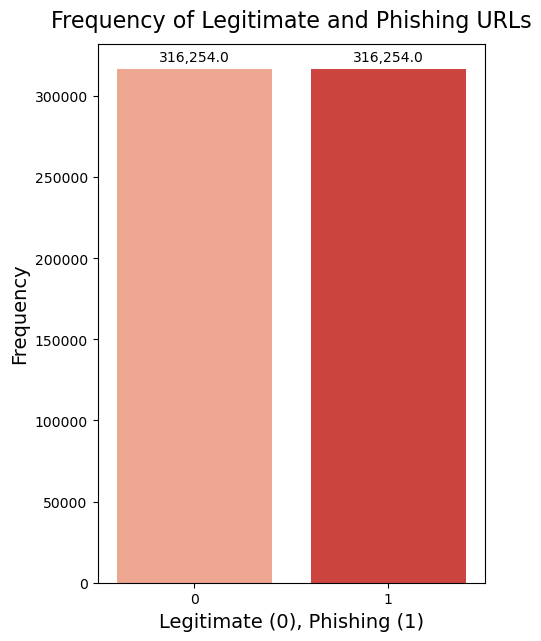

In [7]:
plt.figure(figsize = (5, 7))        
bar = sns.countplot(x=df["label"], 
              data=df, 
              palette="Reds")
for p in bar.patches:
    bar.annotate(format(p.get_height(), ','), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.title('Frequency of Legitimate and Phishing URLs', fontsize = 16, pad = 12)
plt.xlabel('Legitimate (0), Phishing (1)', fontsize = 14)
plt.ylabel("Frequency",fontsize = 14)
plt.show();

# Feature Engineering

In [8]:
import urllib
from urllib.parse import urlparse
import os.path

In [149]:
!pip install tld

In [9]:
df['url_length'] = df['url'].apply(lambda i: len(str(i)))
df['hostname_length'] = df['url'].apply(lambda i: len(urlparse(i).netloc))
df['path_length'] = df['url'].apply(lambda i: len(urlparse(i).path))
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))


In [11]:
characters_to_count = ['-', '@', '?', '%', '.', '=']
df['spcl_char'] = df['url'].apply(lambda i: sum(i.count(char) for char in characters_to_count))

df['count-http'] = df['url'].apply(lambda i : i.count('http'))
df['count-https'] = df['url'].apply(lambda i : i.count('https'))
df['count-www'] = df['url'].apply(lambda i: i.count('www'))

def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
df['count-digits']= df['url'].apply(lambda i: digit_count(i))

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
df['count-letters']= df['url'].apply(lambda i: letter_count(i))

def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

df['path_entropy'] = df['url'].apply(lambda x: -sum([(x.count(c) / len(x)) * (x.count(c) / len(x)) for c in set(x)]))



In [12]:
def count_subdomains(url):
    parsed_url = urlparse(url)
    netloc = parsed_url.netloc
    subdomains = netloc.split('.')
    subdomains = [subdomain for subdomain in subdomains if subdomain != '']
    return len(subdomains)

# Apply the function to calculate subdomain counts and append to 'subdomain' column
df['subdomain'] = df['url'].apply(count_subdomains)

In [13]:
df.head()

,url,result,label,url_length,hostname_length,path_length,fd_length,spcl_char,count-http,count-https,count-www,count-digits,count-letters,count_dir,path_entropy,subdomain
0,https://www.google.com,benign,0,22,14,0,0,2,1,1,1,0,17,0,-0.086777,3
1,https://www.youtube.com,benign,0,23,15,0,0,2,1,1,1,0,18,0,-0.081285,3
2,https://www.facebook.com,benign,0,24,16,0,0,2,1,1,1,0,19,0,-0.076389,3
3,https://www.baidu.com,benign,0,21,13,0,0,2,1,1,1,0,16,0,-0.074830,3
4,https://www.wikipedia.org,benign,0,25,17,0,0,2,1,1,1,0,20,0,-0.081600,3


 Understanding Distribution of features and differences betweeen benign and phishing URLs

In [14]:
num_cols = df.select_dtypes(exclude='object')

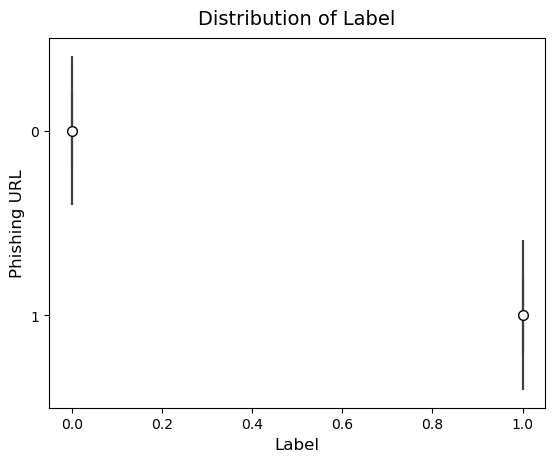

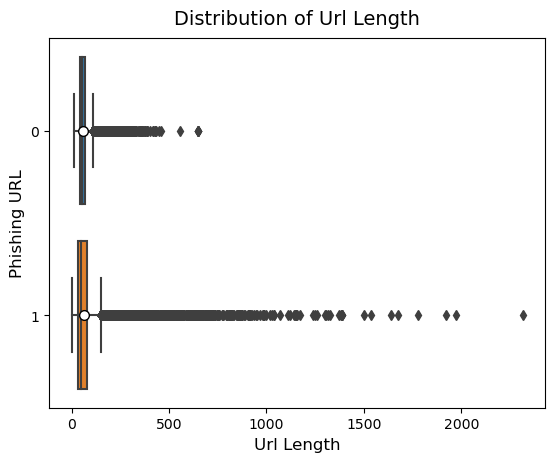

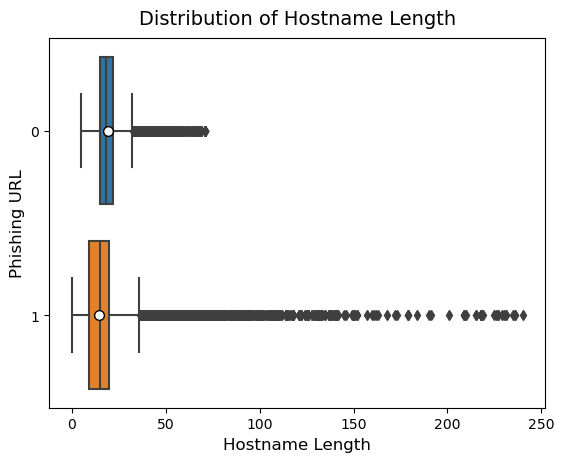

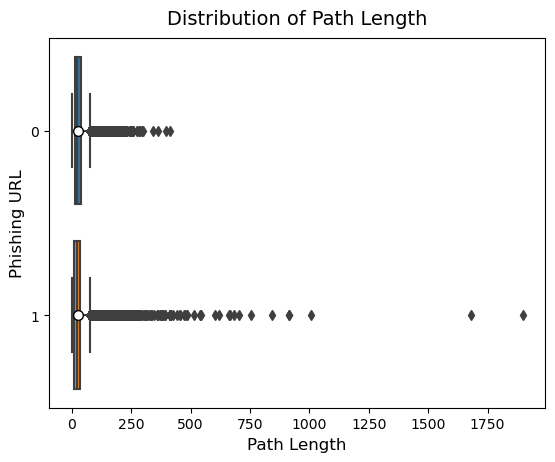

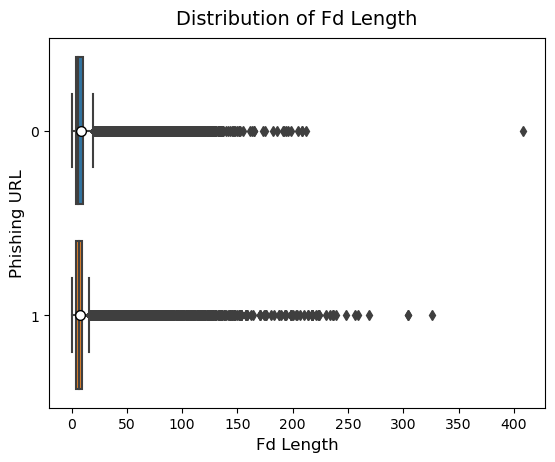

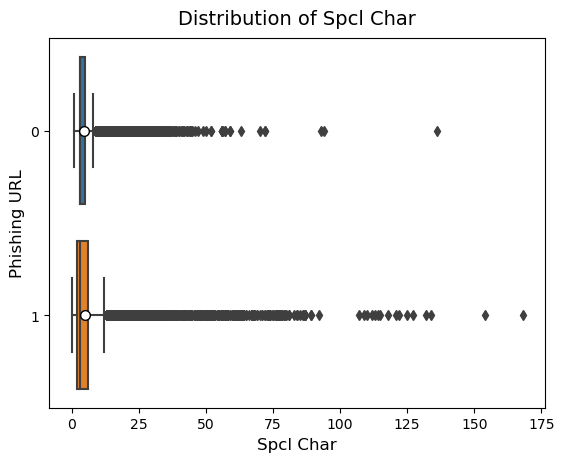

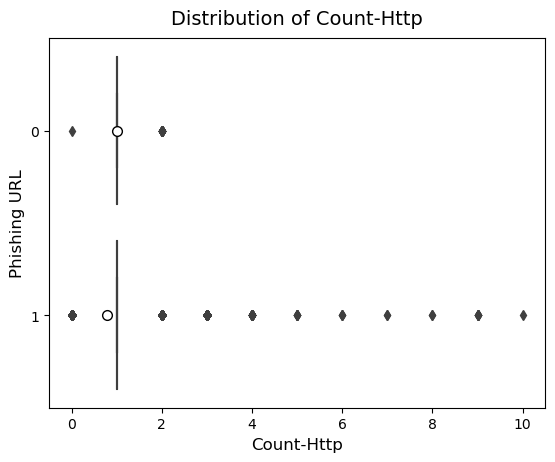

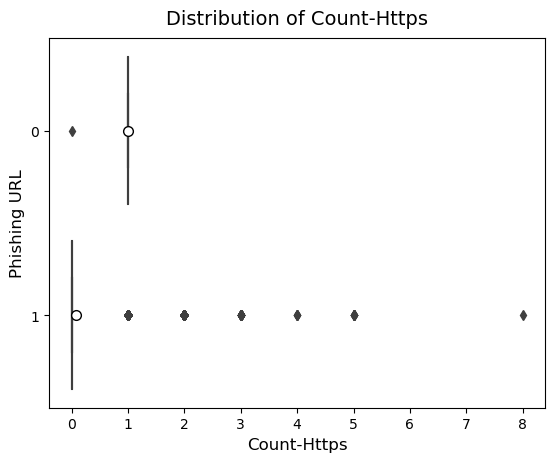

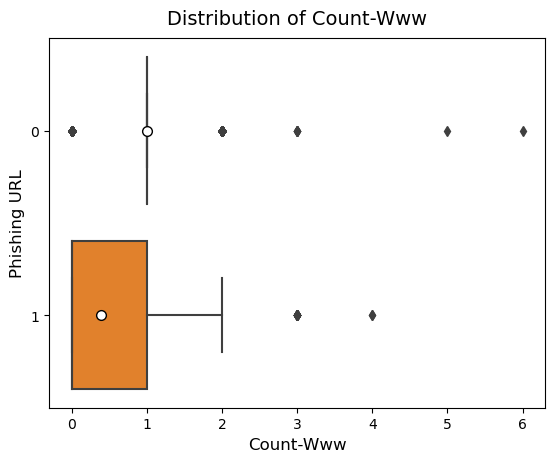

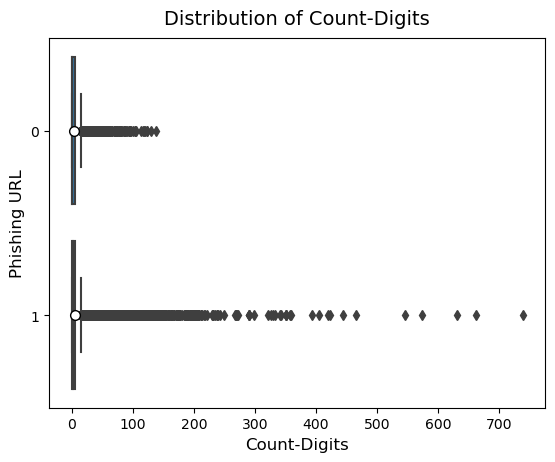

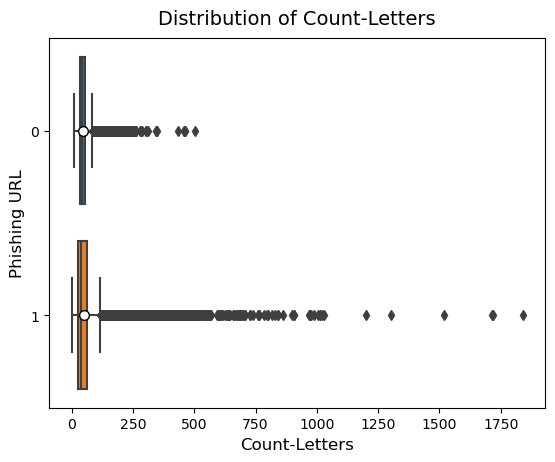

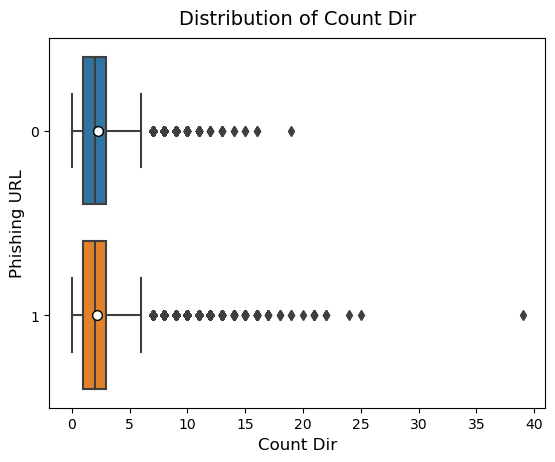

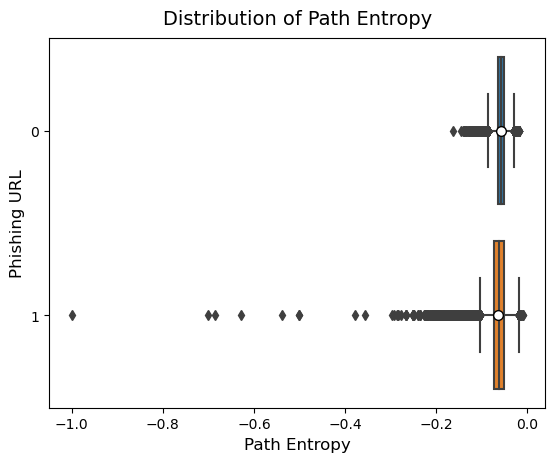

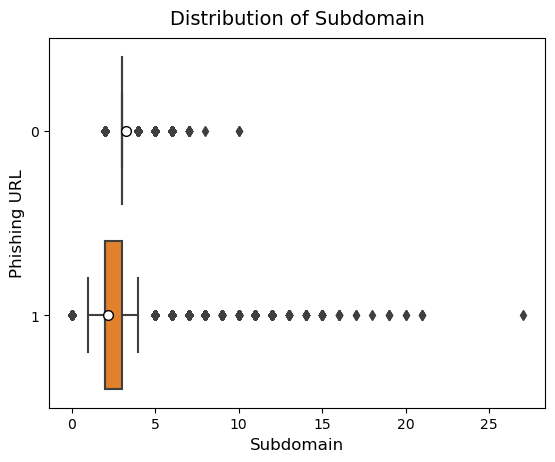

In [15]:
for col in num_cols:
    column_name = col.title().replace('_', ' ')
    title = 'Distribution of ' + column_name
    sns.boxplot(x=df[col],
                y=df['label'],
                data=df,
                orient='h',
                showmeans=True,
                meanprops={"marker":"o",
                           "markerfacecolor":"white", 
                           "markeredgecolor":"black",
                           "markersize":"7"})
    plt.xlabel(column_name, fontsize = 12)
    plt.ylabel('Phishing URL', fontsize = 12)
    plt.title(title, fontsize = 14, pad = 10)
    plt.show()

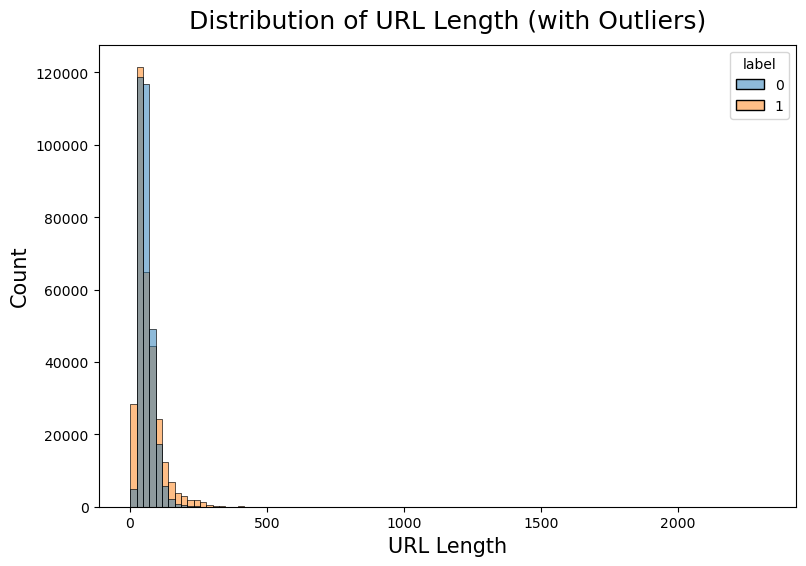

In [16]:
plt.figure(figsize=(9,6))
sns.histplot(data=df, x=df["url_length"], hue = 'label', bins=100)
plt.title('Distribution of URL Length (with Outliers)', fontsize = 18, pad = 12)
plt.xlabel("URL Length", fontsize = 15)
plt.ylabel("Count",fontsize = 15)
plt.show()

In [17]:
Q1 = df['url_length'].quantile(0.25)
Q3 = df['url_length'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_url_length = df[(df['url_length']> lower_bound)]
filtered_url_length = df[(df['url_length']< upper_bound)]

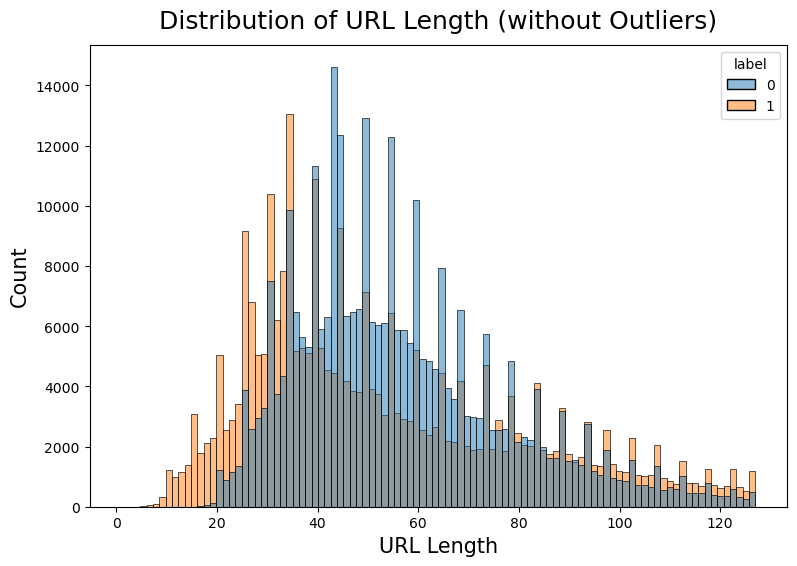

In [18]:
plt.figure(figsize=(9,6))
sns.histplot(data=filtered_url_length, x="url_length", hue = 'label', bins = 100)
plt.title('Distribution of URL Length (without Outliers)', fontsize = 18, pad = 12)
plt.xlabel("URL Length", fontsize = 15)
plt.ylabel("Count",fontsize = 15);
plt.show()

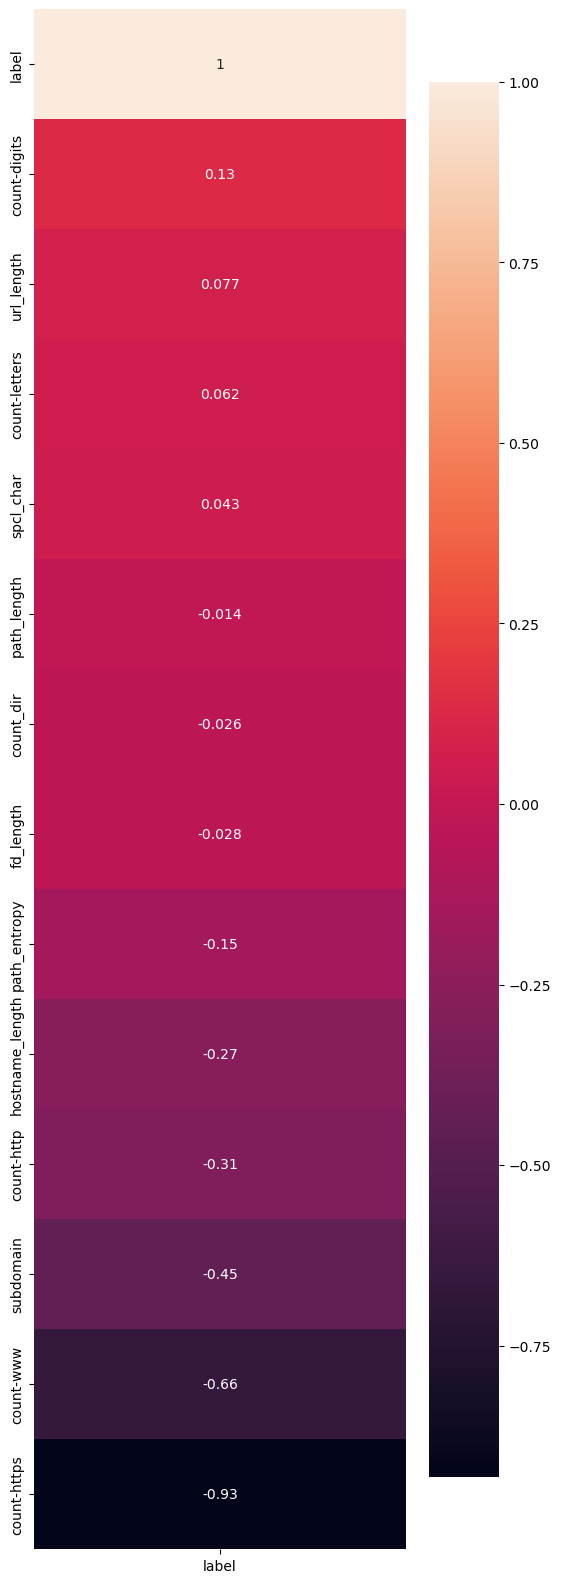

In [20]:
plt.figure(figsize=(6,20))
sns.heatmap(df.corr()[['label']].sort_values('label', ascending=False), annot=True);

In [160]:
df.to_csv('./Data/url_updated.csv', index=False)